## Analyse exploratoire série temporelle - fct_respiratory

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

In [6]:
columns = ['etco2','eto2','fico2','fin2o','fr','fr_ecg','fio2','mac','peeptotal','pmax','pmean','pplat','rr_co2','spo2','svo2__m','vt']

In [21]:
#read data 

fct_respiratory = pd.read_csv('fct_respiratory.csv')
dim_patient = pd.read_csv('dim_patient.csv')
dates = dim_patient[['id_patient','date_transplantation']]

#merge two dataframes per id_patient

df = pd.merge(fct_respiratory, dates, on='id_patient')
df['timestamp'] = df['date_transplantation'] + '-' +df['time']

#remove time = 0 

df = df[df['time'] != '0']

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [22]:
df_melt = pd.melt(df, id_vars=['id_patient','timestamp'], value_vars=columns)

In [8]:
def plot_respiratory(df, id_patient, col):
    print 'Displaying respiratory measures for patient # {}'.format(id_patient)
    g = sns.FacetGrid(df[df['id_patient'] == id_patient], col="variable", col_wrap=4, sharey=False)
    g = g.map(plt.plot, "timestamp", col)

In [9]:
def plot_metric_patient(df, metric, id_patient, col):
    print 'Displaying respiratory measure {} for patient # {}'.format(metric, id_patient)
    df_tmp = df[df['id_patient'] == id_patient]
    df_tmp[df_tmp.variable == metric].plot(x='timestamp', y=col)

## Supprimer les valeurs anormales

Un des challenges dans le traitement des timeseries est la présence de valeurs anormales. Ces valeurs peuvent apparaitre car un instrument de mesure n'est pas correctement configuré etc.. Voici un exemple de valeur anormale: 

Displaying respiratory measure svo2__m for patient # 381


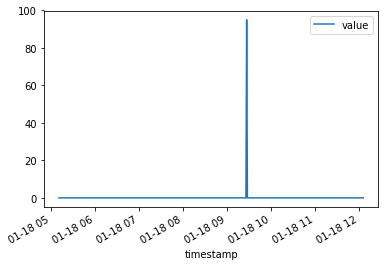

In [10]:
plot_metric_patient(df_melt, 'svo2__m', 381, 'value')

Dans l'exemple ci-dessus une minute du set a une valeur anormale. Nous proposons ici de réaliser un simple check en checkant toute valeur supérieur à un certain quantile (0.99, 0.95 etc..). Si la valeur est en dehors du quantile, nous retournons la mesure précédente: 

In [11]:
def above_quantile(x):
    result = {'q_high': x['value'].quantile(0.95), 
              'q_low': x['value'].quantile(0.05)}
    return pd.Series(result, name='quantiles')

df_melt['shift'] = df_melt.groupby(['id_patient','variable']).value.shift(1)
quant_df = df_melt.groupby(['id_patient', 'variable']).apply(above_quantile).reset_index()
df_melt_2 = pd.merge(df_melt, quant_df)

In [12]:
def previous_value(value, q_high, q_low, shift):
    if (value > q_high) | (value < q_low):
        return shift
    else: 
        return value

In [13]:
v = np.vectorize(previous_value)
df_melt_2['value_2'] = v(df_melt_2['value'], df_melt_2['q_high'], df_melt_2['q_low'], df_melt_2['shift'])

Si nous visualisons cette même mesure, nous avons supprimé la mesure anormale: 

Displaying respiratory measure svo2__m for patient # 381


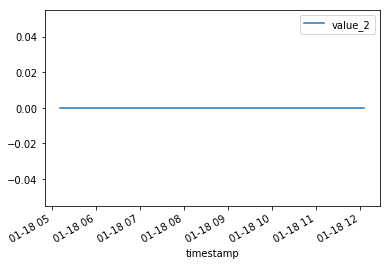

In [14]:
plot_metric_patient(df_melt_2, 'svo2__m', 381, 'value_2')

## Lisser les valeurs temporelles en utilisant une rolling window

Dans cette partie, nous montrons comment nous pouvons simplement lisser les valeurs pics en recourant à une moyenne lissée sur différentes périodes. 

La fonction .rolling permet de préciser différentes "window". Nous appliquons la moyenne sur la colonne value_2: 

In [15]:
r_0 = df_melt_2.groupby(['id_patient', 'variable']).rolling(1, min_periods =1, on='timestamp').value_2.mean()
r_5 = df_melt_2.groupby(['id_patient', 'variable']).rolling(5, min_periods =1, on='timestamp').value_2.mean()
r_10 = df_melt_2.groupby(['id_patient', 'variable']).rolling(10, min_periods =1, on='timestamp').value_2.mean()
r_15 = df_melt_2.groupby(['id_patient', 'variable']).rolling(15, min_periods =1, on='timestamp').value_2.mean()
r_20 = df_melt_2.groupby(['id_patient', 'variable']).rolling(20, min_periods =1, on='timestamp').value_2.mean()

In [16]:
df_roll = pd.concat([r_0, r_5, r_10, r_15, r_20], axis=1)
df_roll.columns = ['r_0', 'r_5', 'r_10', 'r_15', 'r_20']
df_roll = df_roll.reset_index(level=1)

In [19]:
df_roll['norm_max'] = 3

Nous sélectionnons un patient et une variable d'intérêt à visualiser: 

In [24]:
df1 = df_roll.loc[361, :][df_roll.loc[361, :].variable == 'etco2']

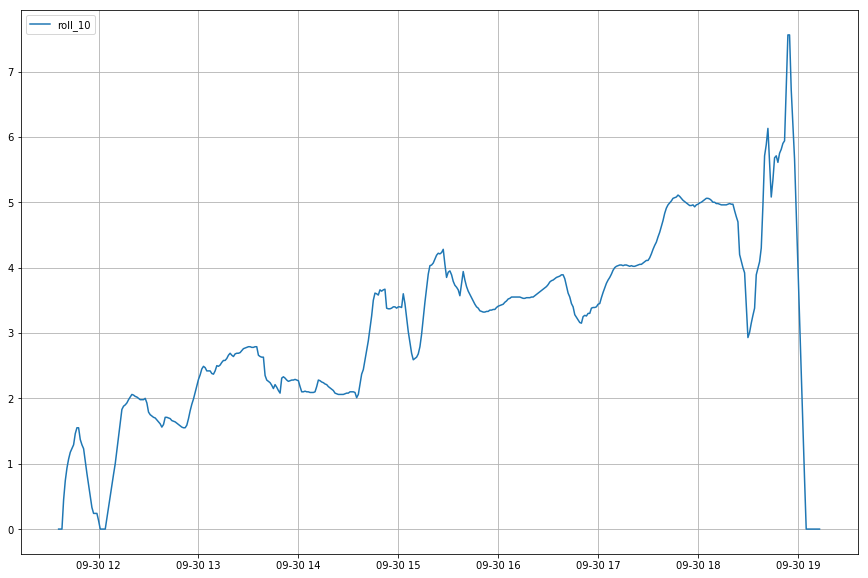

In [28]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df1['r_10'], label='roll_10')
plt.legend(loc=2)